# Implementation of Linear Hard Margin SVMs through CRNs

We shall be implementing linear hard margin SVMs using CRNs

In [196]:
# Format of notebook:
# Give a diagram and explaination of the network
# importing libraries
# defining the helper function
# training
# plotting
# testing
# plotting 


In [197]:
# Give Diagram and explaination of the network

In [198]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [199]:
# helper functions

# defining the various functions
# oscillator function
# load
# sum
# product
# comparison ratio
# approximate majority

In [200]:
# oscillator wrapper function takes in an array of oscillating species names, array of doped species, current timestep
# a dictionary containing all the species concentrations, and an output dictionary for current timestep

def oscillator_function(y,t,num_oscillating_species):
    # making the array of the oscillating species
    oscillating_species = y[0:num_oscillating_species]
    doped_species = y[num_oscillating_species:]

    num_doped_species = len(doped_species)

    # initialisinng the derivatives
    d_oscillating_species = np.zeros(num_oscillating_species)
    d_doped_species = np.zeros(num_doped_species)

    # defining the derivatives 

    # for the oscillating species
    d_oscillating_species[0] = -oscillating_species[0]*oscillating_species[1] + oscillating_species[num_oscillating_species-1]*oscillating_species[0] + doped_species[0]*oscillating_species[num_oscillating_species-1] - doped_species[1]*oscillating_species[0]

    for idx in range(1,num_oscillating_species-1):
        d_oscillating_species[idx] = oscillating_species[idx-1]*oscillating_species[idx] - oscillating_species[idx+1]*oscillating_species[idx] + doped_species[idx]*oscillating_species[idx-1] - doped_species[idx+1]*oscillating_species[idx]
    
    d_oscillating_species[num_oscillating_species-1] = oscillating_species[num_oscillating_species-2]*oscillating_species[num_oscillating_species-1] - oscillating_species[0]*oscillating_species[num_oscillating_species-1] + doped_species[num_doped_species-1]*oscillating_species[num_oscillating_species-2] - doped_species[0]*oscillating_species[num_oscillating_species-1]

    # for the doped species
    d_doped_species[0] = -doped_species[0]*oscillating_species[num_doped_species-1]

    for idx in range(1,num_doped_species):
        d_doped_species[idx] = -doped_species[idx]*oscillating_species[idx-1]
    
    dydt = []
    dydt.extend(d_oscillating_species)
    dydt.extend(d_doped_species)
    
    return dydt

def oscillator_wrapper(oscillating_species, doped_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    
    # making an array of the species concentrations at timestep: current_timestep - 1
    oscillating_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in oscillating_species])
    doped_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in doped_species])

    # number of oscillating species 
    num_oscillating_species = len(oscillating_species_concentrations)

    # making the input array for the oscillator function
    y_0 = []
    y_0.extend(oscillating_species_concentrations)
    y_0.extend(doped_species_concentrations)

    # calculating the time range
    t = np.linspace(current_timestep - 1, current_timestep, 2) # 2 steps

    # solving the ODE
    sol = odeint(oscillator_function, y_0, t, args=(num_oscillating_species,))

    # updating the species concentrations in current timestep
    for idx, species in enumerate(oscillating_species):
        species_concentrations_current_timestep[species] = sol[1][idx]

    for idx, species in enumerate(doped_species):
        species_concentrations_current_timestep[species] = sol[1][num_oscillating_species + idx]

    return species_concentrations_current_timestep





In [201]:
threshold = 0.0001

In [202]:
# laoding function
def load_function(y,t,a, o):
    c = y[0]
    dc_dt = -c*o + a*o
    return [ dc_dt]

def load_wrapper(from_species, to_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    # getting the species concentrations at current timestep - 1
    from_species_concentration = species_concentrations[from_species][current_timestep - 1]
    to_species_concentration = species_concentrations[to_species][current_timestep - 1]
    regulating_species_concentration = species_concentrations[regulating_species][current_timestep - 1]

    y0 = [to_species_concentration]
    t = np.linspace(current_timestep - 1, current_timestep, 2) # 2 steps
    
    sol = odeint(load_function, y0, t, args=(from_species_concentration, regulating_species_concentration))

    if np.abs(sol[1][0] - to_species_concentration) > threshold: # to ensure update only happens when substantial #review
        species_concentrations_current_timestep[to_species] = sol[1][0] # only value of to_species is updated

    return species_concentrations_current_timestep



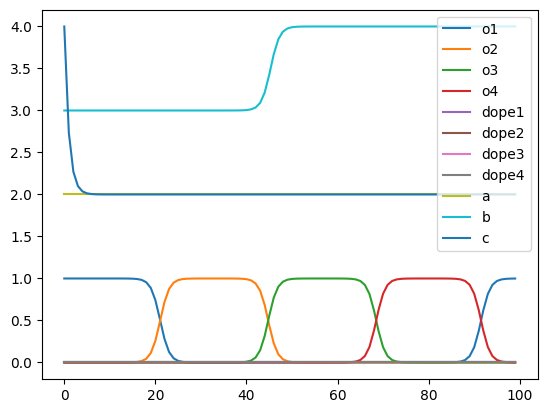

In [208]:
# multiplication function
def product_f(y,t,a,b,o):
    c = y[0]
    dc_dt = -c*o + a*b*o
    return [ dc_dt]

def product_wrapper(multiplicand_1, multiplicand_2, product,regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    # getting the species concentrations at current timestep - 1
    a = species_concentrations[multiplicand_1][current_timestep - 1]
    b = species_concentrations[multiplicand_2][current_timestep - 1]
    c = species_concentrations[product][current_timestep - 1]
    o = species_concentrations[regulating_species][current_timestep - 1]

    y0 = [c]
    t = np.linspace(current_timestep-1, current_timestep,2)
    
    sol = odeint(product_f, y0, t, args=(a,b,o))

    if np.abs(c-sol[1][0]):
        species_concentrations_current_timestep[product] = sol[1][0]

    return species_concentrations_current_timestep

d = 10 **(-10)
species_concentrations = {
    'o1': [1],
    'o2': [0],
    'o3': [0],
    'o4': [0],
    'dope1': [d],
    'dope2': [d],
    'dope3': [d],
    'dope4': [d],
    'a' : [2],
    'b' : [3],
    'c' : [4]
}
ti=1
osc = ['o1', 'o2','o3', 'o4']
dop = ['dope1', 'dope2', 'dope3', 'dope4']

for t in range(1, 100):
    # Get updated concentrations for the current timestep
    updated_concentrations_current_t = oscillator_wrapper(osc, dop, t, species_concentrations, {})
    updated_concentrations_current_t = product_wrapper('a','c','b' ,'o3', t, species_concentrations,updated_concentrations_current_t )
    updated_concentrations_current_t = load_wrapper('a', 'c', 'o1', t, species_concentrations,updated_concentrations_current_t )
    # updated_concentrations_current_t = product_wrapper('a','c', 'b', 'o1', t, species_concentrations, updated_concentrations_current_t)
    
    # Update the species_concentrations dictionary with the new concentrations
    for species in species_concentrations:
        if species in updated_concentrations_current_t:
            species_concentrations[species].append(updated_concentrations_current_t[species])
        else:
            species_concentrations[species].append(species_concentrations[species][t-1])
     
# plotting the  species in the species_concentrations dictionary
for species in species_concentrations:
    plt.plot(species_concentrations[species], label=species)
plt.legend()
plt.show()


In [204]:
print(species_concentrations['o3'])

[0, 1.2210145811373069e-20, 2.3976013869971173e-19, 1.0222276231793703e-18, 3.219222737113756e-18, 9.718366472363137e-18, 2.7499883651423555e-17, 7.67579966396348e-17, 2.1027510521838468e-16, 5.754074877629669e-16, 1.567619494370402e-15, 4.265163781211214e-15, 1.159852708486543e-14, 3.15301089001803e-14, 8.568924421397606e-14, 2.327614400075342e-13, 6.31460287413853e-13, 1.7073443254420688e-12, 4.576022124881813e-12, 1.200531468329915e-11, 3.0141796353147645e-11, 7.123548860566416e-11, 1.6371570527220195e-10, 3.9104526019200836e-10, 9.916457567838435e-10, 2.6155530064515198e-09, 7.02615835642584e-09, 1.9014135982894657e-08, 5.160088952555246e-08, 1.401843622028577e-07, 3.809999166406978e-07, 1.0357625068892663e-06, 2.8165533955135975e-06, 7.662976200513207e-06, 2.0864920628041285e-05, 5.675593561331621e-05, 0.00015431540573652711, 0.0004194188046837469, 0.001139344440407062, 0.0030911187398715476, 0.00835822108722575, 0.022398390776747053, 0.05862875114433461, 0.14478375214633263, 0.31

In [205]:
# # trying out this function
# osc = ['o1', 'o2','o3']
# dop = ['dope1', 'dope2', 'dope3']

# d = 10 **(-15)
# species_concentrations = {
#     'o1': [1],
#     'o2': [0],
#     'o3': [0],
#     'dope1': [d],
#     'dope2': [d],
#     'dope3': [d]
# }


# for t in range(1, 100):
#     # Get updated concentrations for the current timestep
#     updated_concentrations = oscillator_wrapper(osc, dop, t, species_concentrations, {})
    
#     # Update the species_concentrations dictionary with the new concentrations
#     for species in updated_concentrations:
#         species_concentrations[species].append(updated_concentrations[species])

# # print(species_concentrations)

# # plotting the  species in the species_concentrations dictionary
# for species in species_concentrations:
#     plt.plot(species_concentrations[species], label=species)

# plt.legend()
# plt.show()


# d = 10 **(-10)
# species_concentrations = {
#     'o1': [1],
#     'o2': [0],
#     'o3': [0],
#     'o4': [0],
#     'dope1': [d],
#     'dope2': [d],
#     'dope3': [d],
#     'dope4': [d],
#     'a' : [2],
#     'b' : [3],
#     'c' : [4]
# }

# osc = ['o1', 'o2','o3', 'o4']
# dop = ['dope1', 'dope2', 'dope3', 'dope4']

# for t in range(1, 1000):
#     # Get updated concentrations for the current timestep
#     updated_concentrations_osc = oscillator_wrapper(osc, dop, t, species_concentrations, {})
#     updated_concentrations_load = load_wrapper('a', 'c', 'o1', t, species_concentrations,updated_concentrations_osc )
#     updated_concentrations_load = load_wrapper('b', 'a', 'o4', t, species_concentrations,updated_concentrations_load )
    
#     # Update the species_concentrations dictionary with the new concentrations
#     for species in updated_concentrations_load:
#         species_concentrations[species].append(updated_concentrations_load[species])

# # plotting the  species in the species_concentrations dictionary
# for species in species_concentrations:
#     plt.plot(species_concentrations[species], label=species)
# plt.legend()
# plt.show()


In [206]:
# Questions to ask:
# 1. We need to ensure that every module finishes in its first oscillation (i think)
# 2. as doing odeint for basically 1 step, do  i really need to do it? can simply do x_t = x_t-1 + dxdt?
# 3. between oscillations, the transition causes change in concentration of other species Answer: space by 2 oscillations , o1 ,o2, then o3 and also introduce o4
# 4. Different species for read and write (not LHS and RHS in species)
# 5. jumled order of instructions forces us to include change threshold update. do u want that?


# Things to do:
# 1. formalise the notebook, by adding markdowns
# 2. check reviews once
